In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [13]:
#importing shapefiles

population_df = gp.read_file('/Users/poliveira/Library/CloudStorage/OneDrive-CityUniversityofNewYork/CUNY/Spring 24/GEO_COMPUTATION/final_project/data_sets/populacao/Populacao.shp')
average_age_df = gp.read_file('/Users/poliveira/Library/CloudStorage/OneDrive-CityUniversityofNewYork/CUNY/Spring 24/GEO_COMPUTATION/final_project/data_sets/projecao_idade_media/idade_meia_projecao.shp')
urbanization_df = gp.read_file('/Users/poliveira/Library/CloudStorage/OneDrive-CityUniversityofNewYork/CUNY/Spring 24/GEO_COMPUTATION/final_project/data_sets/projecao_grau_de_urbanizacao/grau_de_urbanizacao_projecao.shp')
elderly_ix_df = gp.read_file('/Users/poliveira/Library/CloudStorage/OneDrive-CityUniversityofNewYork/CUNY/Spring 24/GEO_COMPUTATION/final_project/data_sets/indice_envelhecimento/indice_envelhecimento.shp')
mortality_df = gp.read_file('/Users/poliveira/Library/CloudStorage/OneDrive-CityUniversityofNewYork/CUNY/Spring 24/GEO_COMPUTATION/final_project/data_sets/obitos/obitos.shp')
growth_df = gp.read_file('/Users/poliveira/Library/CloudStorage/OneDrive-CityUniversityofNewYork/CUNY/Spring 24/WEB_GIS/sp_data/taxas_crescimento_anual/TX CRESC ANUAL.shp')

DriverError: '/Users/poliveira/Library/CloudStorage/OneDrive-CityUniversityofNewYork/CUNY/Spring 24/GEO_COMPUTATION/final_project/data_sets/populacao/Populacao.shp' not recognized as a supported file format.

In [ ]:
average_age_df = gp.read_file('/Users/poliveira/Library/CloudStorage/OneDrive-CityUniversityofNewYork/CUNY/Spring 24/GEO_COMPUTATION/final_project/data_sets/projecao_idade_media/idade_meia_projecao.shp')

In [369]:
#treating the dataframes before merging them

growth_rename = {
    'ROTULO':'Rotulo'
}

growth_df.rename(columns=growth_rename, inplace=True)
#growth_df_df

elderly_ix_rename = {
    'indenvelhe': 'elderly2019',
    'ROTULO':'Rotulo'
}

elderly_ix_df.rename(columns=elderly_ix_rename, inplace=True)
#elderly_ix_df


mortality_rename = {
    'total': 'morta2019',
    'mun':'Rotulo'
}

mortality_df.rename(columns=mortality_rename, inplace=True)
#mortality_df


average_age_rename = {
    'a1991': 'AGEAVR1991',
    'a2000': 'AGEAVR2000',
    'a2010': 'AGEAVR2010',
    'a2020': 'AGEAVR2020',
    'a2030': 'AGEAVR2030',
    'a2040': 'AGEAVR2040',
    'a2050': 'AGEAVR2050',
    'ROTULO':'Rotulo'
}

average_age_df.rename(columns=average_age_rename, inplace=True)
#average_age_df

urbanization_rename = {
    'a1991': 'URB1991',
    'a2000': 'URB2000',
    'a2010': 'URB2010',
    'a2020': 'URB2020',
    'a2030': 'URB2030',
    'a2040': 'URB2040',
    'a2050': 'URB2050',
    'ROTULO': 'Rotulo'
}

urbanization_df.rename(columns=urbanization_rename, inplace=True)

#urbanization_df

In [404]:
#finding the capital row - which will be dropped off and used to calculate distance

desired_rows = population_df[population_df['Nome'] == 'São Paulo']
desired_rows

#reproject to UTM for distance calculation
projected_crs = 'EPSG:3395'

crs_population_df = population_df.to_crs(projected_crs)

In [400]:
sao_paulo_centroid = crs_population_df.centroid.iloc[562]
distance = ['Rotulo','Distance','Category']
distance_df = pd.DataFrame(index=range(645),columns=distance)


In [38]:
#defining the category for each city based on its distance to the capital 

for i in range (645):

    centroid_new  = crs_population_df.centroid.iloc[i]

    distance_df.loc[i,"Distance"] = sao_paulo_centroid.distance(centroid_new)
    distance_df.loc[i,"Rotulo"] = crs_population_df.loc[i,"Rotulo"]
    
    if distance_df.loc[i,"Distance"] < 100000:
        distance_df.loc[i,"Category"] =0
    elif distance_df.loc[i,"Distance"] < 200000:
        distance_df.loc[i,"Category"] =1 
    elif distance_df.loc[i,"Distance"] < 300000:
        distance_df.loc[i,"Category"] =2
    elif distance_df.loc[i,"Distance"] < 400000:
        distance_df.loc[i,"Category"] =3 
    elif distance_df.loc[i,"Distance"] < 500000:
        distance_df.loc[i,"Category"] =4 
    elif distance_df.loc[i,"Distance"] < 600000:
        distance_df.loc[i,"Category"] =5 
    else:
        distance_df.loc[i,"Category"] =6
    
distance_df

In [365]:
#merging all dataframes 

merged_df = pd.merge(crs_population_df, distance_df, on='Rotulo', how='inner')

merged_df = pd.merge(merged_df, urbanization_df, on='Rotulo', how='inner')

merged_df = pd.merge(merged_df, growth_df, on='Rotulo', how='inner')

merged_df = pd.merge(merged_df, average_age_df, on='Rotulo', how='inner',suffixes=('_left', '_right'))

merged_df = pd.merge(merged_df, elderly_ix_df, on='Rotulo', how='inner')

merged_df = pd.merge(merged_df, mortality_df, on='Rotulo', how='inner',suffixes=('_left2', '_right2'))

merged_df = merged_df.drop(562)


In [ ]:
#creating a new dataframe for each category

unique_categories = merged_df['Category'].unique()

# Create new DataFrames for each unique category
new_dataframes = {}
for category in unique_categories:
    new_dataframes[category] = merged_df[merged_df['Category'] == category].copy()

# Accessing the new DataFrames
print("New DataFrames:")
for category, category_df in new_dataframes.items():
    print(f"\nCategory: {category}")
    print(category_df)

In [420]:
#calculating statitics for each variable to be plot

stats_values = {'Category': [], 'Mean_Value_Pop': [], 'Total_pop': [], 'Max_Pop_Value': [],'Area_Total':[],'Age_Mean':[],'Morta_Mean':[],
                'Elderly_Mean':[],'Growth_Rate':[]}

for category, category_df in new_dataframes.items():
    mean_value_pop = category_df['Pop'].mean()
    total_pop = category_df['Pop'].sum()
    max_value = category_df['Pop'].max()
    age_mean = category_df['AGEAVR2020'].mean()
    morta_mean = (category_df['morta2019'].sum()/category_df['Pop'].sum())
    area_sum = category_df['Area_Km2_x'].sum()
    eld_mean = category_df['elderly2019'].mean()
    growth_mean = category_df['Tx_Cres'].mean()
    
    stats_values['Category'].append(category)
    stats_values['Mean_Value_Pop'].append(mean_value_pop)
    stats_values['Total_pop'].append(total_pop)
    stats_values['Max_Pop_Value'].append(max_value)
    stats_values['Age_Mean'].append(age_mean)
    stats_values['Morta_Mean'].append(morta_mean)
    stats_values['Area_Total'].append(area_sum)
    stats_values['Elderly_Mean'].append(eld_mean)
    stats_values['Growth_Rate'].append(growth_mean)


stats_df = pd.DataFrame(stats_values)

print(stats_df)

   Category  Mean_Value_Pop  Total_pop  Max_Pop_Value  Area_Total   Age_Mean  \
0         5    16621.703297    1512575         223679    34357.57  38.616484   
1         4    22270.255102    2182485         455272    36372.60  37.373469   
2         1    72484.778846    7538417        1193760    41532.61  36.143269   
3         2    28343.480392    2891035         246868    52692.67  36.036275   
4         3    32320.796460    3652250         699238    41027.88  36.819469   
5         0   182978.629630   14821269        1383287    19204.41  35.083951   
6         6    11995.904762     503828          56153    18302.21  38.902381   

   Morta_Mean  Elderly_Mean  Growth_Rate  
0    0.009179    133.094396     0.119341  
1    0.008625    109.639082     0.434286  
2    0.007231     92.992500     0.830000  
3    0.007950     93.441275     0.129412  
4    0.007915    104.911504     0.292566  
5    0.006883     79.004321     1.059259  
6    0.009225    140.910714     0.212381  


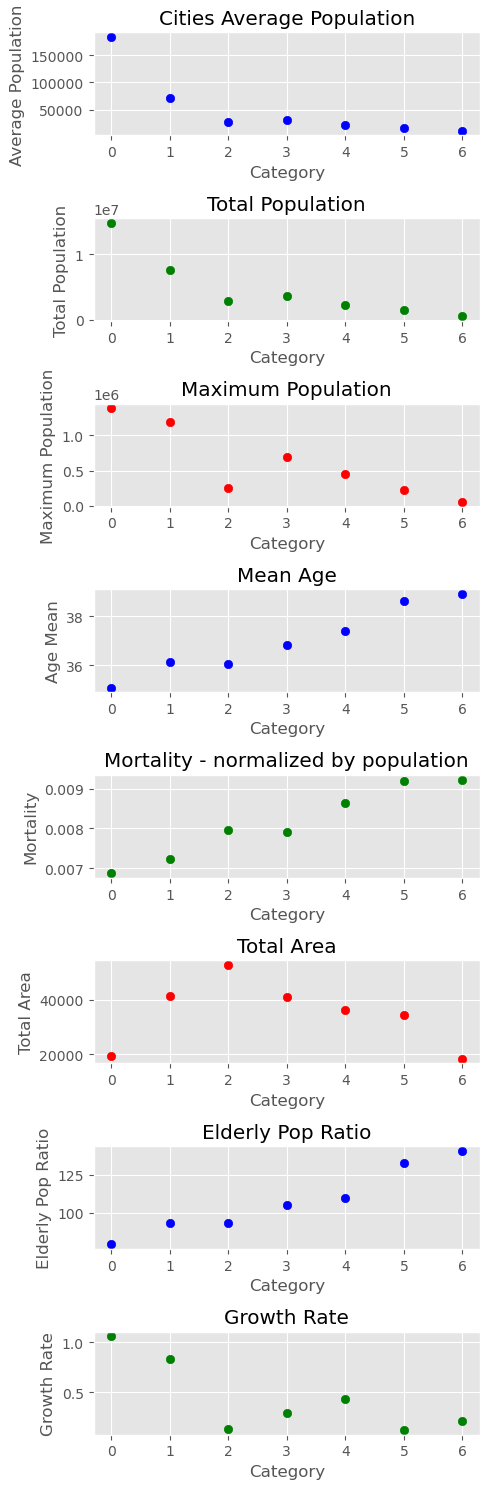

In [422]:
#creating subplots

fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(5, 15))

categories = stats_df['Category']

mean_values = stats_df['Mean_Value_Pop']
sum_values = stats_df['Total_pop']
max_values = stats_df['Max_Pop_Value']
age_values = stats_df['Age_Mean']
morta_mean = stats_df['Morta_Mean']
area_sum = stats_df['Area_Total']
eld_mean = stats_df['Elderly_Mean']
growth_mean = stats_df['Growth_Rate']

axes[0].scatter(categories, mean_values, marker='o', color='blue')
axes[0].set_title('Cities Average Population')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Average Population')


axes[1].scatter(categories, sum_values, marker='o', color='green')
axes[1].set_title('Total Population')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Total Population')


axes[2].scatter(categories, max_values, marker='o', color='red')
axes[2].set_title('Maximum Population')
axes[2].set_xlabel('Category')
axes[2].set_ylabel('Maximum Population')


axes[3].scatter(categories, age_values, marker='o', color='blue')
axes[3].set_title('Mean Age')
axes[3].set_xlabel('Category')
axes[3].set_ylabel('Age Mean')


axes[4].scatter(categories, morta_mean , marker='o', color='green')
axes[4].set_title('Mortality - normalized by population')
axes[4].set_xlabel('Category')
axes[4].set_ylabel('Mortality')


axes[5].scatter(categories, area_sum, marker='o', color='red')
axes[5].set_title('Total Area')
axes[5].set_xlabel('Category')
axes[5].set_ylabel('Total Area')


axes[6].scatter(categories, eld_mean, marker='o', color='blue')
axes[6].set_title('Elderly Pop Ratio')
axes[6].set_xlabel('Category')
axes[6].set_ylabel('Elderly Pop Ratio')


axes[7].scatter(categories, growth_mean, marker='o', color='green')
axes[7].set_title('Growth Rate')
axes[7].set_xlabel('Category')
axes[7].set_ylabel('Growth Rate')

plt.tight_layout()

plt.savefig('plots.png')

plt.show()



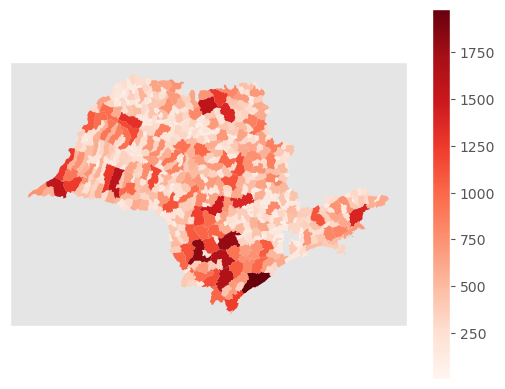

In [396]:
# ploting maps 
gdf = gp.GeoDataFrame(crs_population_df, geometry='geometry')

ax = gdf.plot(column='Area_Km2', cmap='Reds', legend=True)

plt.xticks([])
plt.yticks([])

plt.savefig('area_map.png')

plt.show()

<Figure size 2500x500 with 0 Axes>

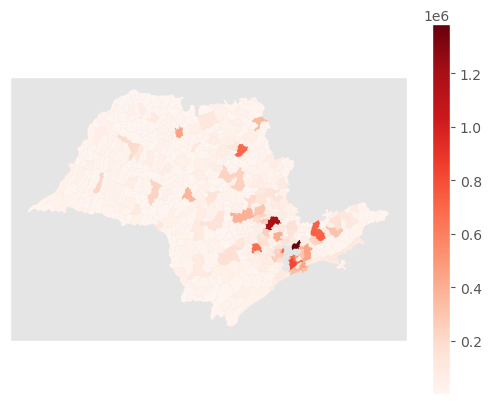

In [398]:
gdf = gp.GeoDataFrame(crs_population_df, geometry='geometry')

plt.figure(figsize=(25, 5))

gdf.plot(column='Pop', cmap='Reds', legend=True)

plt.xticks([])
plt.yticks([])

plt.savefig('population.png')

plt.show()

<Figure size 2500x500 with 0 Axes>

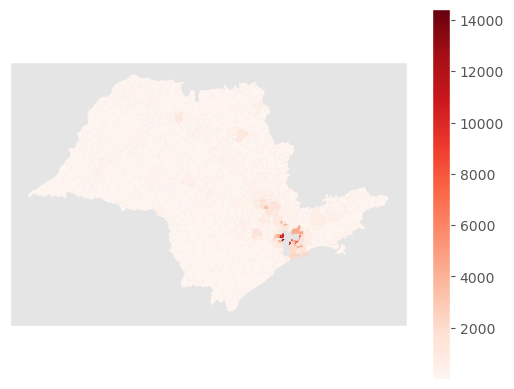

In [397]:

gdf = gp.GeoDataFrame(crs_population_df, geometry='geometry')

plt.figure(figsize=(25, 5))

gdf.plot(column='Den_Demo', cmap='Reds', legend=True)

plt.xticks([])
plt.yticks([])

plt.savefig('den_demo.png')

plt.show()

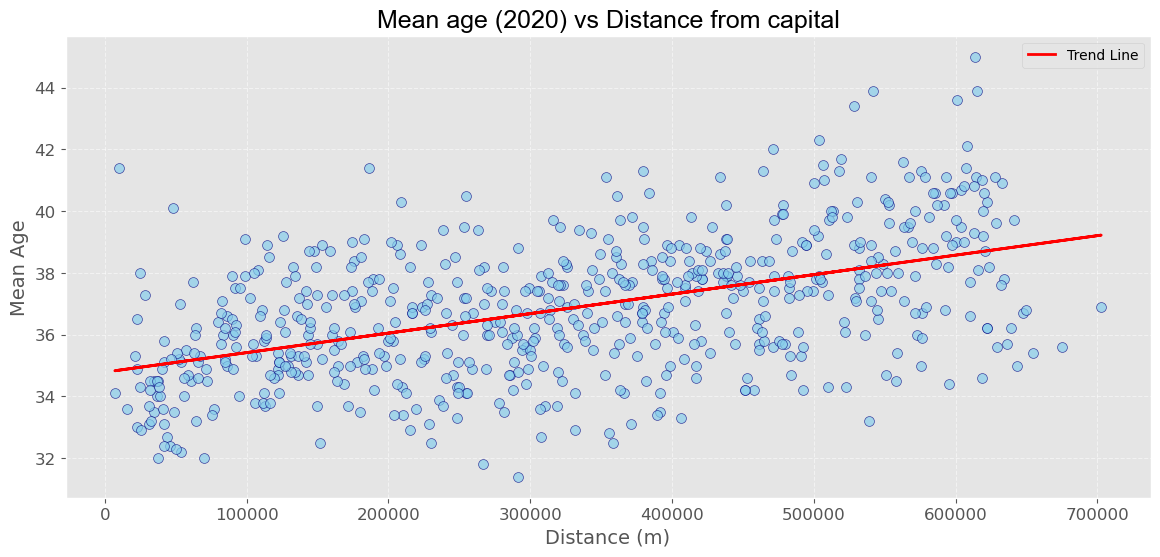

In [384]:
# ploting graphs and trendlines
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(merged_df['Distance'], merged_df['AGEAVR2020'], color='skyblue', edgecolor='navy', alpha=0.7, s=50)

merged_df['Distance'] = pd.to_numeric(merged_df['Distance'])
merged_df['AGEAVR2020'] = pd.to_numeric(merged_df['AGEAVR2020'])

m, b = np.polyfit(merged_df['Distance'], merged_df['AGEAVR2020'], 1)
ax.plot(merged_df['Distance'], m * merged_df['Distance'] + b, color='red', linestyle='-', linewidth=2, label='Trend Line')

ax.set_title('Mean age (2020) vs Distance from capital', fontsize=18, fontname='Arial')
ax.set_xlabel('Distance (m)', fontsize=14)
ax.set_ylabel('Mean Age', fontsize=14)
ax.legend()

ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, linestyle='--', alpha=0.5)

plt.savefig('mean_age.png')

plt.show()


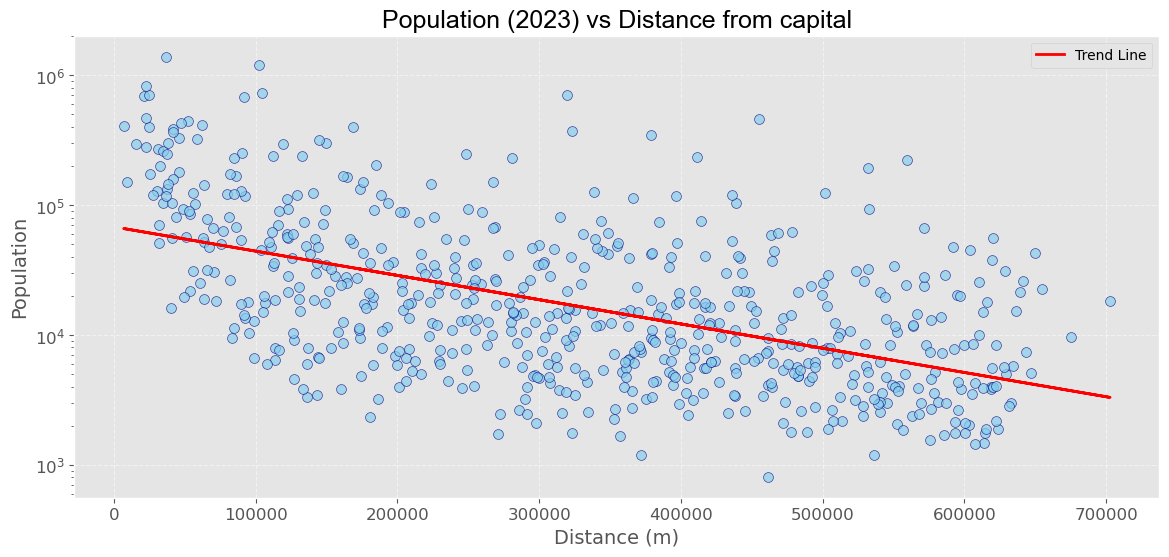

In [383]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(14, 6))

merged_df['Distance'] = pd.to_numeric(merged_df['Distance'])
merged_df['Pop'] = pd.to_numeric(merged_df['Pop'])

ax.scatter(merged_df['Distance'], merged_df['Pop'], color='skyblue', edgecolor='navy', alpha=0.7, s=50)

params = np.polyfit(merged_df['Distance'], np.log(merged_df['Pop']), 1)
a = np.exp(params[1])
b = params[0]
ax.plot(merged_df['Distance'], a * np.exp(b * merged_df['Distance']), color='red', linestyle='-', linewidth=2, label='Trend Line')


ax.set_title('Population (2023) vs Distance from capital', fontsize=18, fontname='Arial')
ax.set_xlabel('Distance (m)', fontsize=14)
ax.set_ylabel('Population', fontsize=14)
ax.legend()


ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_yscale('log')

ax.grid(True, linestyle='--', alpha=0.5)

plt.savefig('population.png')

plt.show()

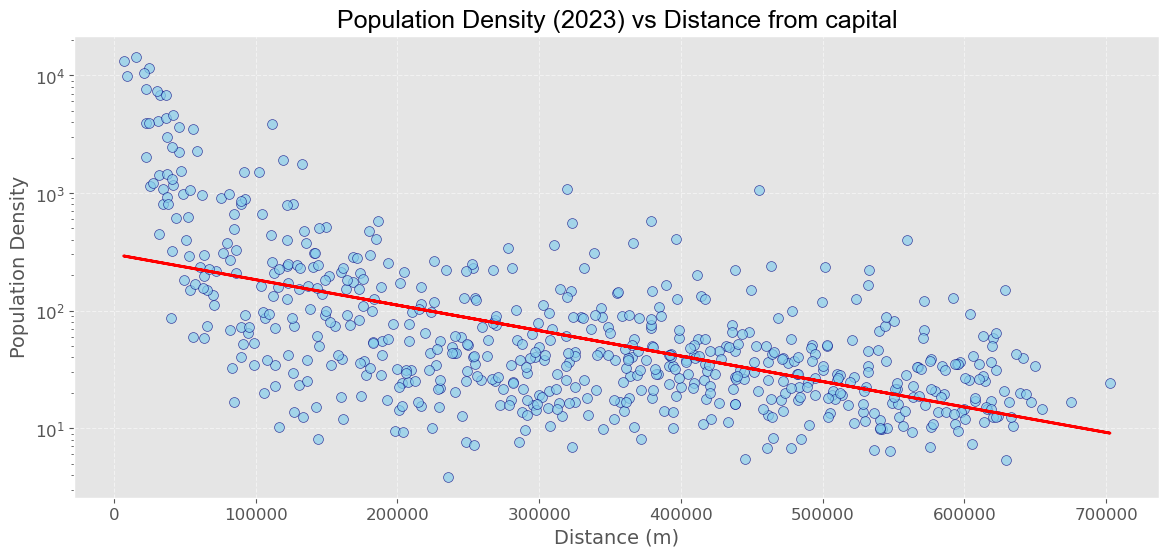

In [386]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(merged_df['Distance'], merged_df['Den_Demo'], color='skyblue', edgecolor='navy', alpha=0.7, s=50)

merged_df['Distance'] = pd.to_numeric(merged_df['Distance'])
merged_df['Den_Demo'] = pd.to_numeric(merged_df['Den_Demo'])

params = np.polyfit(merged_df['Distance'], np.log(merged_df['Den_Demo']), 1)
a = np.exp(params[1])
b = params[0]
ax.plot(merged_df['Distance'], a * np.exp(b * merged_df['Distance']), color='red', linestyle='-', linewidth=2, label='Trend Line')


ax.set_title('Population Density (2023) vs Distance from capital', fontsize=18, fontname='Arial')
ax.set_xlabel('Distance (m)', fontsize=14)
ax.set_ylabel('Population Density', fontsize=14)

ax.set_yscale('log')

ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, linestyle='--', alpha=0.5)

plt.savefig('population_den.png')

plt.show()

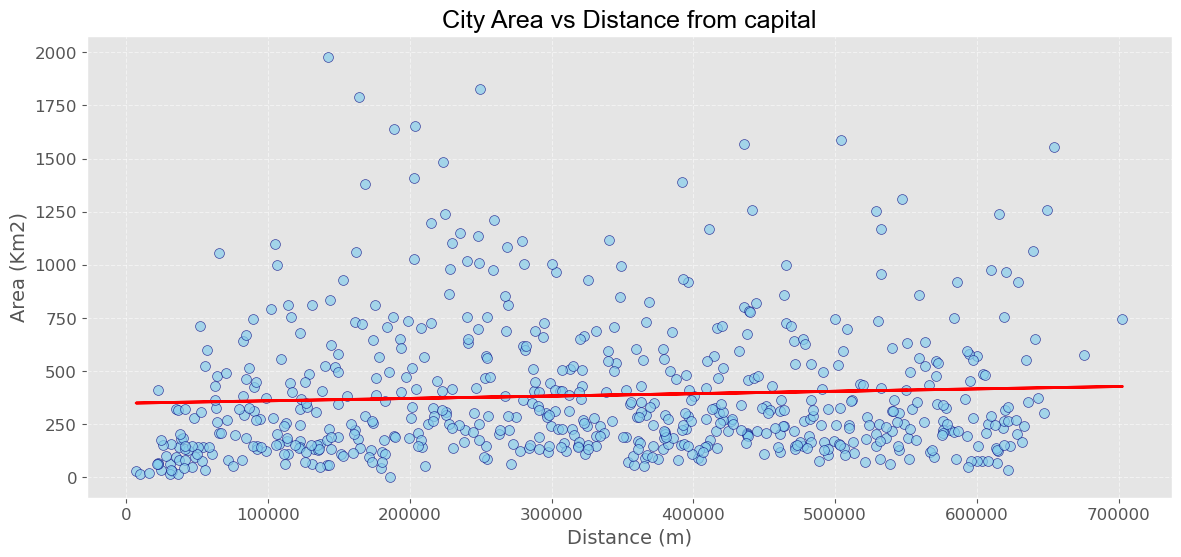

In [390]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(14, 6))

ax.scatter(merged_df['Distance'], merged_df['Area_Km2_x'], color='skyblue', edgecolor='navy', alpha=0.7, s=50)

m, b = np.polyfit(merged_df['Distance'], merged_df['Area_Km2_x'], 1)
ax.plot(merged_df['Distance'], m * merged_df['Distance'] + b, color='red', linestyle='-', linewidth=2, label='Trend Line')

ax.set_title('City Area vs Distance from capital', fontsize=18, fontname='Arial')
ax.set_xlabel('Distance (m)', fontsize=14)
ax.set_ylabel('Area (Km2)', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, linestyle='--', alpha=0.5)

plt.savefig('area.png')

plt.show()

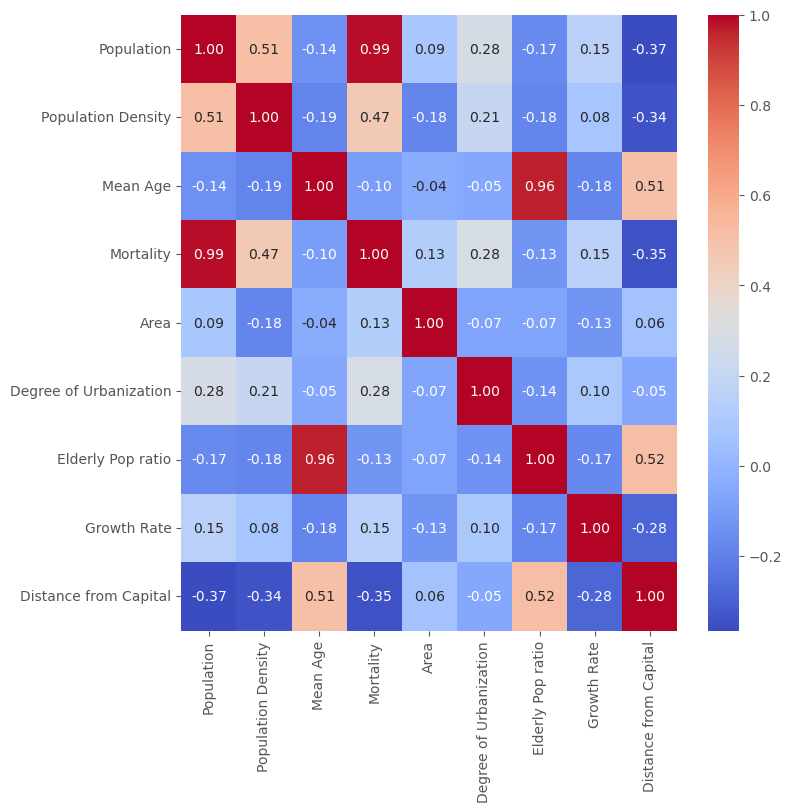

In [418]:
#ploting correlation using seaborn 

columns = ['Pop','Den_Demo','AGEAVR2020','morta2019','Area_Km2_x','URB2020','elderly2019','Tx_Cres','Distance']  # Specify the columns you want to include

sel_columns_df = merged_df[columns]

corr_matrix = sel_columns_df.corr()

custom_labels = {
    'Pop': 'Population',
    'Den_Demo': 'Population Density',
    'AGEAVR2020': 'Mean Age',
    'morta2019': 'Mortality',
    'Area_Km2_x': 'Area',
    'URB2020': 'Degree of Urbanization',
    'elderly2019': 'Elderly Pop ratio',
    'Tx_Cres': 'Growth Rate',
    'Distance': 'Distance from Capital'
}


corr_matrix = corr_matrix.rename(index=custom_labels, columns=custom_labels)


plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.savefig('correlation.png', bbox_inches='tight')
plt.show()

